# Use photometric data to correct images

## 1. Build the masterbias

Antes de empezar el proyecto, importaremos todas las librerías que usaremos. Estas serán 'fits' desde 'astropy.io' para poder manipular los archivos '.fit', 'matplotlib.pyplot' para graficar las imagenes, 'numpy' para facilitar el manejo de arrays y para obterner promedios, medianas entre otros usos matemáticos. Y por último la librería 'os', que nos ayudará a manejarnos por los archivos que se encuentran dentro de la carpeta.

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os

Ya con las librerías importadas, entraremos a la carpeta que contiene los archivos '.fit' y extraeremos todos los datos de los bias frames (archivos que tengan 'Bias' en el nombre) en una lista.\
Los bias frames son imágenes con tiempo de exposición casi cero y con el obturador cerrado, i.e. no hay luz incidente. Esto nos dará como resultado una imágen en la que sólo se registrará el nivel de voltaje de lectura de los píxeles con el fin de corregir el ruido electrónico.

In [2]:
path= '/home/labfis026/Downloads/image_data_reduction/OBS_20220427/'
path_files= os.listdir(path)
bias= []
for i in path_files:
    if 'Bias' in i:
        hdul= fits.open(path+i)[0].data
        bias.append(hdul)
print('Número de archivos Bias: ', len(bias))

Número de archivos Bias:  10


Como se puede ver, dentro de la carpeta hay 10 bias frames.\
Ahora, para crear la masterbias debemos juntar todos estos frames en uno. Esto lo haremos con la función de numpy 'mean' (se puede hacer tanto con el promedio como con la mediana de los frames), el cual hará un promedio de los datos que los 10 bias frames tienen creando un solo archivo llamado masterbias. El parámetro 'axis=0' que se utiliza es para que el promedio se realice sobre las columnas del array.\
Luego, usando la función 'imshow' de matplotlib podremos ver la imagen generada del masterbias.

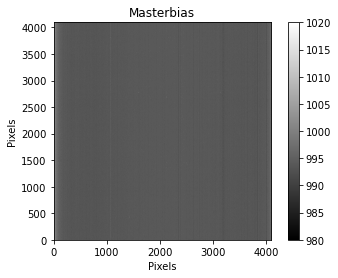

In [3]:
masterbias= np.mean(bias, axis=0)
plt.imshow(masterbias, vmin=980, vmax=1020, cmap='gray', origin='lower')
plt.title('Masterbias')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar()

Para que la masterbias se aprecie mejor, le ajustamos los valores mínimos y máximos de la escala de color de la imagen entre 980 y 1020.

Ahora construiremos un histograma con los datos del masterbias para tener de forma visual la cantidad de píxeles con cierto valor de ADU (cantidad de luz que ha sido capturada por el CCD en cada píxel durante una exposición). Para esto debemos transformar la matriz de la masterbias a una dimensión usando '.flatten()', y luego usando matplotlib graficamos un histograma con dichos datos en 100 intervalos (bins).

Text(0, 0.5, 'Number of pixels')

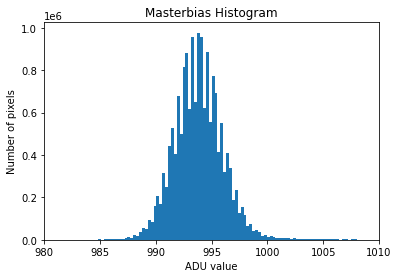

In [4]:
masterbias_flat= masterbias.flatten()
plt.hist(masterbias_flat, bins=100, range=(982,1008))
plt.xlim([980, 1010])
plt.title('Masterbias Histogram')
plt.xlabel('ADU value')
plt.ylabel('Number of pixels')

Como se puede ver, la distribución se asemeja a una campana de Gauss.\
Valores importantes de este histograma son el promedio y desviación estandar, para así poder corregir el corrimiento de señal del detector y obtener imágenes más precisas.

In [5]:
mean= np.mean(masterbias_flat)
std= np.std(masterbias_flat)
print('Mean: ', mean)
print('Standar Deviation: ', std)

Mean:  993.8497814595697
Standar Deviation:  2.2847825648112576


## 2. Build a masterdark

Ahora vamos a construir un masterdark a partir de los dark frames que se encuentran en la carpeta.\
Los dark frames son imágenes que se sacan sin luz con el fin de ver como afecta la señal de ruido térmico a ciertos píxeles para luego poder realizar correciones a la imagen final.

Dentro de la carpeta con los frames extraeremos todos los datos de los archivos que contengan 'Dark' en su nombre (dark frames) y los guardaremos en una lista vacía, así como sus tiempos de exposición en otra lista. Estos tiempos de exposición se pueden encontrar dentro de los 'header' de cada archivo fit.

In [6]:
dark= []
exptimes=[]
for i in path_files:
    if 'Dark' in i:
        hdul= fits.open(path+i)
        data= hdul[0].data
        time= hdul[0].header['EXPTIME']
        dark.append(data)
        exptimes.append(time)
print('Número de archivos Dark: ', len(dark))
print('Tiempos de exposición: ', exptimes)

Número de archivos Dark:  3
Tiempos de exposición:  [300.0, 240.0, 180.0]


Como se puede ver, solo hay 3 dark frames con sus respectivos.\
Para hacer el masterdark debemos restar a cada dark frame el masterbias que creamos anteriormente y a todo eso hay que dividirlo por el tiempo de exposición de dicho dark frame (MASTERDARK = COMBINATION OF ((DARK_i - MASTERBIAS) /Texp_dark_i )). Todos esos resultados los guardaremos en una lista vacía.

In [7]:
darker= []
j= 0
for i in dark:
    var= np.array((i-masterbias)/exptimes[j], dtype=float)
    darker.append(var)
    j+=1

Finalmente, calcularemos el promedio de dichos datos como lo hicimos para el masterbias con 'np.mean' obteniendo así el masterdark.\
Para graficar la imagen usaremos la función 'plt.imshow' y ajustaremos los valores mínimos y máximos de la escala de color de la imagen entre '-0.2 y 1.

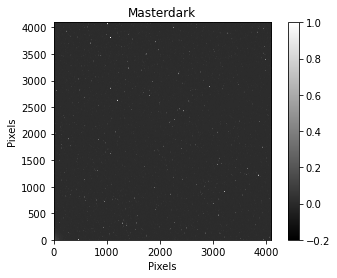

In [8]:
masterdark= np.mean(darker, axis=0)
plt.imshow(masterdark, vmin=-0.2, vmax=1, cmap='gray', origin='lower')
plt.title('Masterdark')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar()

Ahora, al igual que como hicimos con el masterbias, construiremos un histograma con los datos del masterdark.\
Primero, usando el comando '.flatten()' pasamos la matriz del masterdark a una dimensión para poder así, con matplotlib, graficar un histograma de 30 intervalos.

Text(0, 0.5, 'Number of pixels')

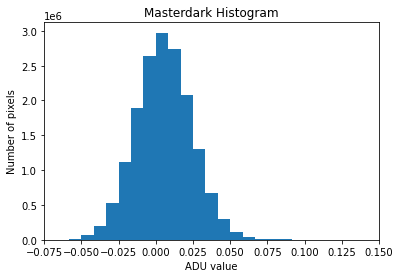

In [9]:
masterdark_flat= masterdark.flatten()
plt.hist(masterdark_flat, bins=30, range=(-0.1, 0.15))
plt.xlim([-0.075, 0.15])
plt.title('Masterdark Histogram')
plt.xlabel('ADU value')
plt.ylabel('Number of pixels')

El promedio y la desviación estandar de la distribución se puede calcular usando las funciones de numpy 'np.mean()' para el promedio y 'np.std()' para de desviación estandar. Estos datos sirven para entender cual es la intensidad media de ruido provocado por la temperatura del sensor o el tiempo de exposición. Mientras que la desviación estandar nos da idea de como se distribuye dicho ruido, ya que el histograma se asemeja a una campana de Gauss.

In [10]:
mean= np.mean(masterdark_flat)
std= np.std(masterdark_flat)
print('Mean: ', mean)
print('Standar Deviation: ', std)

Mean:  0.008993529342390892
Standar Deviation:  0.2811870134096091


## 3. Build a masterflat

Por último antes de poder corregir la imagen completa debemos hacer un masterflat.\
Un masterflat se crea juntando todos los flat frames de un mismo filtro. El masterflat permite corregir patrones de ruido, entre otras variaciones en la sensibilidad del detector.

In [11]:
filtros= []
for i in path_files:
    if 'Flat' in i:
        hdul= fits.open(path+i)
        filter= hdul[0].header['FILTER']
        filtros.append(filter)
print(filtros)

['B', 'sloan_r', 'V', 'V', 'V', 'V', 'sloan_r', 'B', 'B', 'V', 'V', 'B', 'V', 'V', 'B', 'B', 'sloan_r', 'B', 'V', 'V', 'V', 'B', 'B', 'V', 'sloan_r', 'sloan_r', 'sloan_r', 'V']


Para este caso usaremos el filtro 'V', ya que tiene más imagenes que los otros filtros. Ya sabiendo que filtro vamos a usar recorreremos todos los flat frames (archivos con 'Flat' en el nombre), y si tienen el filtro 'V' agregaremos sus datos a una lista vacía y su tiempo de exposición en otra.

In [12]:
flat= []
exptimes= []
for i in path_files:
    if 'Flat' in i:
        hdul= fits.open(path+i)
        if hdul[0].header['FILTER'] == 'V':
            data= hdul[0].data
            time= hdul[0].header['EXPTIME']
            flat.append(data)
            exptimes.append(time)
print('Número de archivos Flat: ', len(flat))
print('Tiempos de exposición: ', exptimes)

Número de archivos Flat:  13
Tiempos de exposición:  [3.0, 0.1, 3.0, 4.0, 2.0, 4.0, 2.0, 1.0, 0.1, 2.0, 3.0, 4.0, 2.0]


Como podemos ver, hay 13 flat frames que usan el filtro 'V'.\
Ahora para hacer el masterflat debemos a cada flat frame restarle el masterbias y el masterdar multiplicado por el tiempo de exposición de dicho flat frame (MASTERFLAT = COMBINATION (FLAT_i - MASTERBIAS - MASTERDARK*Texp_flat_i)). Cada dato corregido, lo agregaremos a una lista vacía.

In [13]:
flatter= []
j= 0
for i in flat:
    var= np.array(i-masterbias-masterdark*exptimes[j], dtype=int)
    flatter.append(var)
    j+=1

Ya con la lista de los flat frames corregidos, debemos promediar toda la lista para obtener el masterflat. Esto lo haremos con ayuda de la función de numpy 'np.mean()', y luego usando la función de matplotlib 'plt.imshow()' graficaremos el masterflat obtenido.

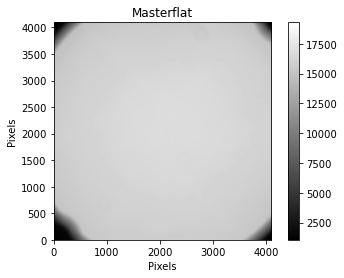

In [14]:
masterflat= np.mean(flatter, axis=0)
plt.imshow(masterflat, cmap='gray', origin='lower')
plt.title('Masterflat')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar()

Contruyamos el histograma del masterflat. Primero pasamos la matriz del masterflat a una dimensión con el comando '.flatten()' y este lo graficamos usando la función de matplotlib 'plt.hist()'.

Text(0, 0.5, 'Number of pixels')

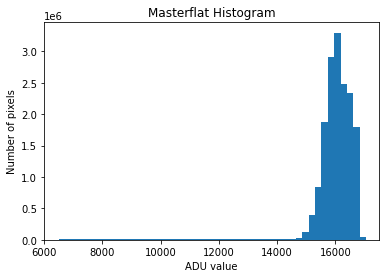

In [15]:
masterflat_flat= masterflat.flatten()
plt.hist(masterflat_flat, bins=50, range=(6500,17500))
plt.xlim([6000,17500])
plt.title('Masterflat Histogram')
plt.xlabel('ADU value')
plt.ylabel('Number of pixels')

Este histograma es ligeramente diferente respecto a los histogramas anteriores. A pesar de que también se parece a una Gaussiana, esta tiene una gran cola en los valores más pequeños de ADU. Esto se debe a las esquinas oscuras del gráfico, ya que en esas regiones del CCD llega una menor cantidad de electrones y el gradiente de color que vemos desde las esquinas hacia el centro crea dicha cola.

Ahora calculemos el promedio y la desviación estandar del histograma.

In [16]:
mean= np.mean(masterflat_flat)
std= np.std(masterflat_flat)
print('Mean: ', mean)
print('Standar Deviation: ', std)

Mean:  15774.519777820662
Standar Deviation:  1814.2673392492395


Como se podía supones del histograma, su desviación estandar es bastante alta debido a los valores de las esquinas de la CCD.

Para hacer la correción total de la imagen no se usa el masterflat como tal, sino que se usa el masterflat normalizado. Para normalizarlo, dividiremos todos los datos del masterflat entre el promedio de sus valores, haciendo así que todos los valores del masterflat se acerquen a la unidad.

In [17]:
masterflat_norm= masterflat/np.mean(masterflat)

Ya con el masterflat normalizado, volveremos a graficar la nueva imagen para ver como los valores mínimos y máximos de la escala de color se acercaron más a la unidad, i.e. la imagen fue normalizada.

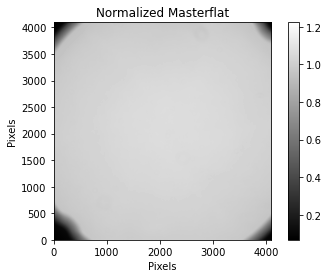

In [18]:
plt.imshow(masterflat_norm, cmap='gray', origin='lower')
plt.title('Normalized Masterflat')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar()

También graficaremos su respectivo histograma para compararlo con el que no está normalizado.

Text(0, 0.5, 'Number of pixels')

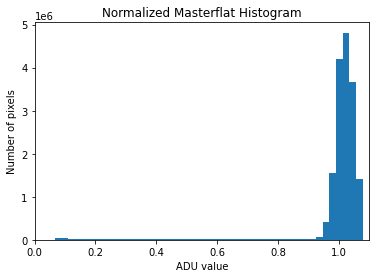

In [19]:
masterflat_normflat= masterflat_norm.flatten()
plt.hist(masterflat_normflat, bins=50, range=(0,1.1))
plt.xlim([0, 1.1])
plt.title('Normalized Masterflat Histogram')
plt.xlabel('ADU value')
plt.ylabel('Number of pixels')

## 4. Corrected an uncorrected image plotting

Ya con todos los master frames vamos a corregir una imagen.\
Los archivos fit que contienen imagenes son los light frames. En este caso vamos a corregir la imagen sacada a una galaxia sombrero. Para esto, vamos a extraer todos los datos de los light frames que tengan el filtro 'V' (filtro con el que trabajamos los flat frames), y los agregaremos a una lista vacía, mientras que en otra lista guardaremos los tiempos de exposición de dichas imagenes.

In [20]:
light_img= []
exptimes= []
for i in path_files:
    if fits.open(path+i)[0].header['FILTER'] == 'V' and 'Light' in i:
        hdul= fits.open(path+i)
        time= hdul[0].header['EXPTIME']
        light_img.append(hdul[0].data)
        exptimes.append(time)
print('Número de light frames con filtro \'V\': ', len(light_img))
print('Tiempos de exposición: ', exptimes)

Número de light frames con filtro 'V':  2
Tiempos de exposición:  [240.0, 120.0]


Como se puede ver, hay 2 light frames con el filtro 'V'.\
Para corregir los frames individuales, a cada uno le restaremos el masterbias y el masterdark multiplicado por el tiempo de exposición de la imagen corregida, y todo eso, lo dividiremos por el masterflat normalizado ([IMAGE - MASTERBIAS - MASTERDARK*Texp_image] / NORMALIZED MASTERFLAT).

In [21]:
corrected= []
j= 0
for i in light_img:
    var= np.array((i-masterbias-masterdark*exptimes[j])/masterflat_norm, dtype=float)
    corrected.append(var)
    j+=1

Luego, juntaremos todas la imagenes corregidas con la función 'np.mean()' y graficaremos la imagen corregida con la función 'plt.imshow()'.

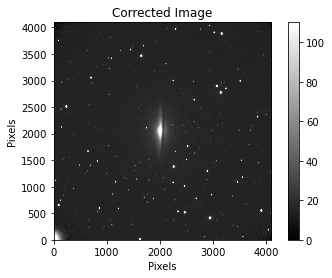

In [22]:
master_corrected= np.mean(corrected, axis=0)
plt.imshow(master_corrected, vmin=0, vmax=110, cmap='gray', origin='lower')
plt.title('Corrected Image')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar()

Para que la imagen se pudiera ver correctamente debemos ajustar los valores mínimos y máximos de la escala de color de la imagen.

Para la imagen sin corregir solo debemos promediar todas las imagenes que tenían el filtro que elegimos anteriormente sin usar los master frames.

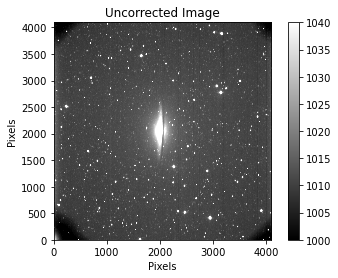

In [23]:
master_uncorrected= np.mean(light_img, axis=0)
plt.imshow(master_uncorrected, vmin=1000, vmax=1040, cmap='gray', origin='lower')
plt.title('Uncorrected Image')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar()

Al comparar ambas imágenes una al lado de la otra es notable la diferencia, pero para ver el cambio de forma más precisa podemos restar los datos de las dos imágenes y realizar un gráfico de eso.

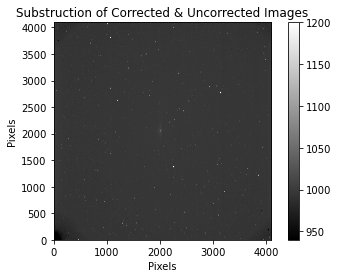

In [24]:
dif= master_uncorrected-master_corrected
plt.imshow(dif, vmin=940, vmax=1200, cmap='gray', origin='lower')
plt.title('Substruction of Corrected & Uncorrected Images')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar()

Al realizar la resta de las dos imágenes lo que nos queda al gráficar son todos los elementos corregidos. Dependiendo de los valores que usemos para la escala de color se pueden ver con mayor claridad. En este caso específico se ve que corrige en las esquinas, en el centro de la galaxia observada y varios puntos producto del masterdark.\
El oscurecimiento de las esquinas de las imagenes sin corregir se puede deber a un efecto que ocurre en los telescopios llamado 'viñeteado'. Puede ser producido por la geometría óptica del sistema de imagen donde a las esquinas de la CCD llegan los fotones llegan con un mayor ángulo de incidencia, provocando así una perdida de información.